[View in Colaboratory](https://colab.research.google.com/github/daphnei/weakvideo/blob/master/visualize_faces.ipynb)

In [5]:
#@title Run this to clone the code repo.
! git clone https://github.com/daphnei/weakvideo.git


Cloning into 'weakvideo'...
remote: Counting objects: 340, done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 340 (delta 42), reused 40 (delta 23), pack-reused 254
Receiving objects: 100% (340/340), 216.35 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [0]:
#@title Run this to pull from the code repo if its already been cloned.
! cd weakvideo; git pull

In [0]:
#@title Python imports

!pip install editdistance

import sys
import os
import numpy as np
import scipy
import scipy.ndimage
import skimage.color
import random

sys.path.append(os.path.abspath(os.path.join('weakvideo/code')))

import utils
import visualization as vis
import cluster_all

In [0]:
#@title Loads in data from nlpgrid.

# Need to update the paths in here too:
!wget www.seas.upenn.edu/~daphnei/GoT.zip
!unzip -o GoT.zip 

In [0]:
#@title Formatting for plots.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
fig_size = [18, 9]
plt.rcParams["figure.figsize"] = fig_size

In [0]:
#@title Helper function to display faces using matplotlib.
def showFaces(faces):
  if len(faces) == 0:
    print('No faces to visualize.')
  numFacesPerRow = 30
  rowsOfFaces = []
  faceIdx = 0
  faceDim = faces[0].image.shape[0]
  while faceIdx < len(faces):
    facesForRow = faces[faceIdx:faceIdx+numFacesPerRow]
    rowsOfFaces.append(facesForRow)
    faceIdx += numFacesPerRow
  vis.visualizeImageGrid(rowsOfFaces, faceDim, numFacesPerRow, outputPath=None)


# Face Filtering

In [0]:
#@title Choose the episode to visualize filtering for.
episode = 4 #@param {type:"slider", min:1, max:7, step:1}

charactersFile = 'Character_count_episode%d.csv' % (episode)
cutsFile = 'CUTS_episode%d.csv' % (episode)
faceDataFile = 'face_data_episode%d.pkl' % (episode)

facesDict = utils.pickleToFaces(faceDataFile)
allFaces = []
for cut in facesDict.keys():
  allFaces.extend(facesDict[cut])
  
tweet_stream_offsets = [2.43333, 1.23333, 1.45000, 1.41667, 1.43333, 1.55000, 1.53333]
offset = tweet_stream_offsets[episode-1]

charactersForEp = utils.processCharactersFile(charactersFile, offset)
cutsForEp = utils.readCuts(cutsFile)

94 of 1094 faces get filtered out for being too dark.


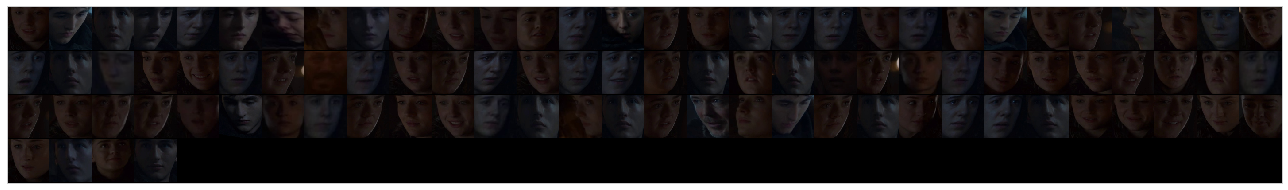

In [13]:
#@title Filter by face darkness. Threshold is of V (value) in HSV color-space.
darknessThreshold = 30 #@param {type:"number"}

def tooDark(face, threshold):
  hsvImage = mpl.colors.rgb_to_hsv(face.image)
  meanValue = np.mean(hsvImage[:,:,2])
  return meanValue < threshold

darkFaces = []
for face in allFaces:
  if tooDark(face, darknessThreshold):
    darkFaces.append(face)
    
print('%d of %d faces get filtered out for being too dark.' % (len(darkFaces), len(allFaces)))

showFaces(darkFaces)

74 of 1094 faces get filtered out for being too small.


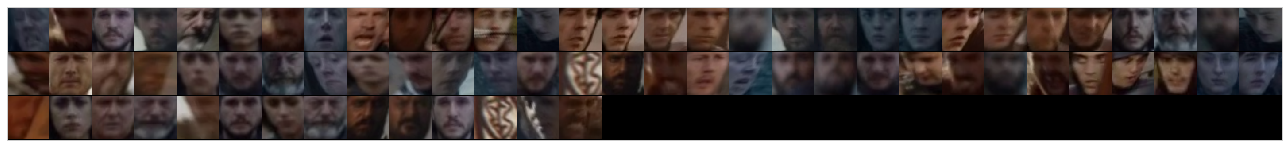

In [14]:
#@title Filter by face size. Threshold is width/height in pixels.
sizeThreshold = 37 #@param {type:"number"}

def tooSmall(face, threshold):
  br = face.bbBottomRight
  tl = face.bbTopLeft
  
  height = br[1] - tl[1]
  width = br[0] - tl[0]
  return height < threshold or width < threshold

smallFaces = []
for face in allFaces:
  if tooSmall(face, sizeThreshold):
    smallFaces.append(face)
    
print('%d of %d faces get filtered out for being too small.' % (len(smallFaces), len(allFaces)))

showFaces(smallFaces)

Size seems to be a bad filtering metric, so I will ommit from later filtering steps.

44 of 1094 faces get filtered out for being too blurry.


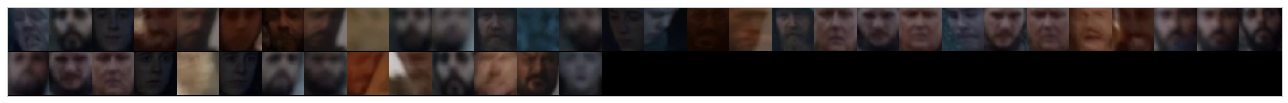

In [16]:
#@title Filter by face blurriness. Threshold is standard deviation of Laplacian.
blurrinessThreshold = 0.007 #@param {type:"number"}

def tooBlurry(face, threshold):
  im = face.image
  im = skimage.color.rgb2gray(im)
  L = scipy.ndimage.filters.laplace(im)
  std = np.std(L)
  
  return std < threshold

blurryFaces = []
for face in allFaces:
  if tooBlurry(face, blurrinessThreshold):
    blurryFaces.append(face)
    
print('%d of %d faces get filtered out for being too blurry.' % (len(blurryFaces), len(allFaces)))

showFaces(blurryFaces)

In [0]:
#@title For a random selection of faces, shows which characters were discussed in the specified interval after the face appeared.
minutes = 3 #@param {type:"slider", min:0, max:10, step:1}
numFacesToShow = 1 #@param {type:"slider", min:1, max:10, step:1}
randomSeed = 654321 #@param {type:"integer"}

temp_fig_size = [3, 3]
plt.rcParams["figure.figsize"] = temp_fig_size

random.seed(randomSeed)

filteredFaces = list(set(allFaces) - set(blurryFaces) - set(darkFaces))

for idx in range(numFacesToShow):
  face = random.choice(filteredFaces)
  
  faceTime = face.getTime(cutsForEp)
  charactersForFace = utils.charactersAtTimeT(faceTime, charactersForEp, minutes*60.)
  charactersForFace = sorted(charactersForFace, key=lambda x: x[1], reverse=True)
  face.characters = charactersForFace

  print('Characters Tweeted about for following image:')
  for char_count in face.characters:
    print('%s\t%d' % char_count)
  plt.imshow(face.image)
  plt.show()

plt.rcParams["figure.figsize"] = fig_size


# Clustering

In the previous section we visualized the results for filtering on the faces for a single episode. In this next section, we peform filtering on all the episodes using the thresholds chosen in the previous section.

(You'll need to run the code from the previous section for this section to run successfully)

##numClusters is only relavent for kmeans and spectral.

In [4]:
#@title Run clustering on all the faces in all the episodes.
method = 'kmeans' #@param ["berg2004", "kmeans", "spectral", "agglomerative"] {type:"string"}
numClusters = 30 #@param {type:"integer"}

args = {'inputFaceFiles': 'face_data_paths.tsv',
        'numClusters': numClusters, # Not relevant for berg2004 or agglomerative methods
        'method': 'berg2004',
        'blurrinessThreshold' : blurrinessThreshold,
        'darknessThreshold' : darknessThreshold,
        'sizeThreshold' : sizeThreshold, # This does not seem to be that effect so commenting out
       }
cluster_all.main(args)

--Return--
> <ipython-input-4-588135acf5e0>(2)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) method
'kmeans'


KeyboardInterrupt: ignored